# LJ Constituent Eta
The purpose of this notebook is to look into the eta distribution of the four possible constiuents of a Lepton Jet:
1. Muon
    * PF Muon
    * DSA Muon
3. Electron
4. Photon



## Imports

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
import hist
import numpy as np
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
# sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # from ABCD_study notebook
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, cutflow
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm

def addStats(H):
    ''' This adds a Statistics box for the histogram that is passed. It shows count, mean, and STD. '''
    stats = (np.atleast_1d(H.profile(axis=0).view())[0])
    count , mean , sumDeltaSquared = int(stats['count']), stats['value'], stats['_sum_of_deltas_squared']
    std = np.sqrt(sumDeltaSquared/count)
    statbox = '' +f'{"Entries:":<{10}}{count:d}' + '\n' + f'{"Mean:":<{10}}{mean:.3f}' + '\n' + f'{"Std Dev:":<{10}}{std:.3f}'
    return statbox

## Define Samples

In [2]:
samples_2mu2e = [
    "2Mu2E_500GeV_5p0GeV_0p8mm",
    "2Mu2E_500GeV_5p0GeV_8p0mm"
]

samples_4mu = [
    "4Mu_500GeV_0p25GeV_0p004mm",
    "4Mu_500GeV_0p25GeV_0p04mm",
    # "4Mu_500GeV_0p25GeV_0p4mm",
    # "4Mu_500GeV_0p25GeV_2p0mm",
    # "4Mu_500GeV_0p25GeV_4p0mm",
    
    # "4Mu_500GeV_1p2GeV_0p019mm",
    # "4Mu_500GeV_1p2GeV_0p19mm",
    # "4Mu_500GeV_1p2GeV_1p9mm",
    # "4Mu_500GeV_1p2GeV_9p6mm",
    # "4Mu_500GeV_1p2GeV_19p0mm",
    
    # "4Mu_500GeV_5p0GeV_0p08mm",
    # "4Mu_500GeV_5p0GeV_0p8mm",
    # "4Mu_500GeV_5p0GeV_8p0mm",
    # "4Mu_500GeV_5p0GeV_40p0mm",
    # "4Mu_500GeV_5p0GeV_80p0mm",
]

samples_bkg = [
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
    "TTJets",
    "QCD_Pt15To20",
    "QCD_Pt20To30",
    "QCD_Pt30To50",
    "QCD_Pt50To80",
    "QCD_Pt80To120",
    "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
    "QCD_Pt470To600",
    "QCD_Pt600To800",
    "QCD_Pt800To1000",
    "QCD_Pt1000",
]

## Make Filesets & Run Processor

In [7]:
#fileset_2mu2e = utilities.make_fileset(samples_2mu2e, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")
fileset_4mu = utilities.make_fileset(samples_4mu, "llpNanoAOD_v2", max_files=10, location_cfg="signal_4mu_v10.yaml")
fileset_bkg = utilities.make_fileset(samples_bkg, "skimmed_llpNanoAOD_v2", max_files=10, location_cfg="backgrounds.yaml")


runner = processor.Runner(
    #executor=processor.DaskExecutor(client=client),
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(), 
    schema=NanoAODSchema,
    maxchunks=1, 
    skipbadfiles=True
)

channels = [
    "base",
    #"baseNoLjNoLjsource",
    "jake_test_select",
    #"baseNoLj",
    #"2mu2e",
    "4mu",
]

p = sidm_processor.SidmProcessor(
    channels,
    ['lj_base'], #hist_collections.py
    #lj_reco_choices=["0.4"],
    #unweighted_hist=True,
)

output = runner.run(fileset_4mu, treename="Events", processor_instance=p)
out = output["out"]

bkg_output = runner.run(fileset_bkg, treename="Events", processor_instance=p)
bkg_out = bkg_output["out"]
 

Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


Signal not in xs cfg, assuming 1fb
Signal not in xs cfg, assuming 1fb


Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/usr/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


KeyboardInterrupt: 

## Plotting Individual Samples

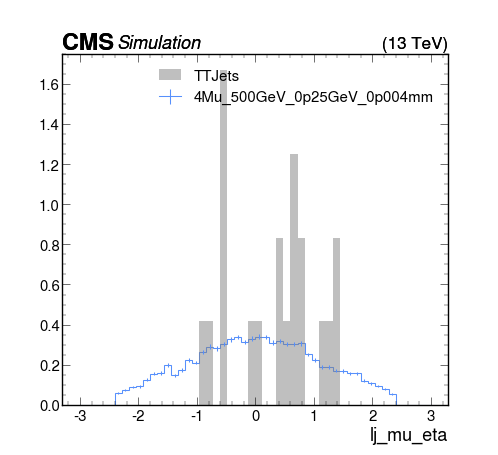

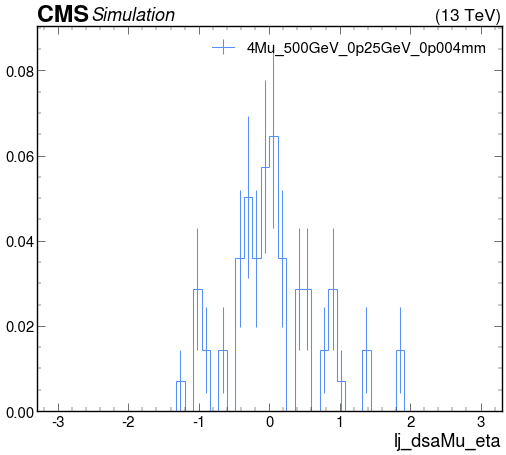

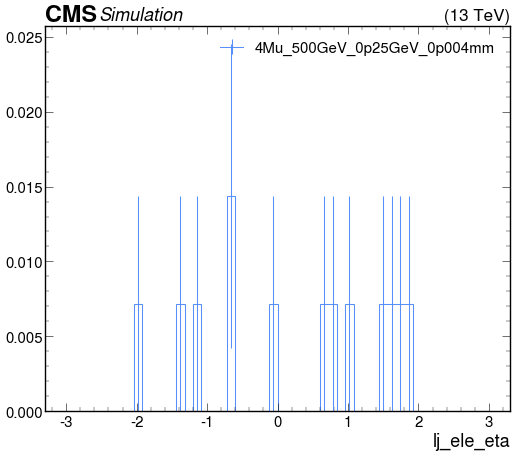

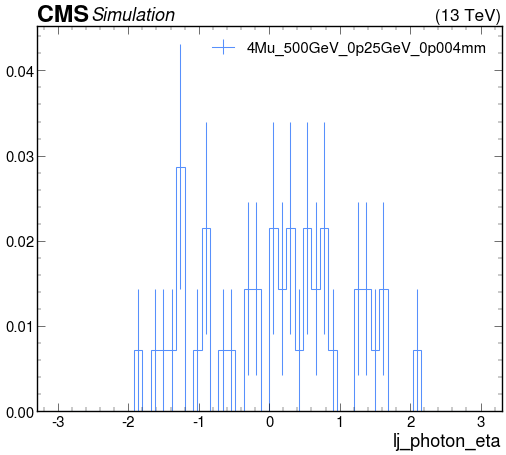

In [4]:
plotting_sample = samples_4mu[0]
bkg_plotting_sample = samples_bkg[2]
plt.subplots(1,1,figsize=(12,10))
utilities.plot(out[plotting_sample]["hists"]["lj_muon_eta"][channels[0], :], density=True, label=plotting_sample)
utilities.plot(bkg_out[bkg_plotting_sample]["hists"]["lj_muon_eta"][channels[0], :], density=True, label=bkg_plotting_sample, color="gray", histtype='bar', alpha=.5)
plt.legend()

plt.subplots(1,1,figsize=(12,10))
utilities.plot(out[plotting_sample]["hists"]["lj_dsaMuon_eta"][channels[0], :], density=False, label=plotting_sample)
plt.legend()

plt.subplots(1,1,figsize=(12,10))
utilities.plot(out[plotting_sample]["hists"]["lj_electron_eta"][channels[0], :], density=False, label=plotting_sample)
plt.legend()

plt.subplots(1,1,figsize=(12,10))
utilities.plot(out[plotting_sample]["hists"]["lj_photon_eta"][channels[0], :], density=False, label=plotting_sample)
plt.legend()

## Plotting All 4 Constituents (1 Sample)

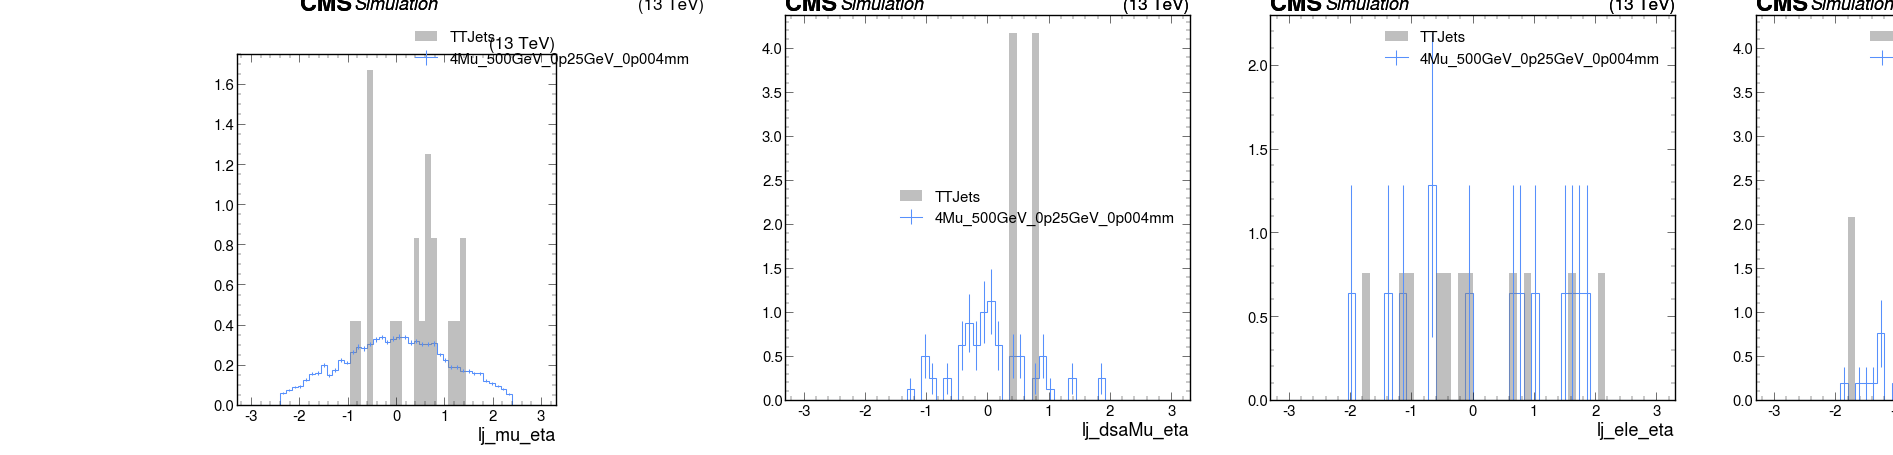

In [5]:
plotting_sample = samples_4mu[0]
bkg_plotting_sample = samples_bkg[2]
fig, axes = plt.subplots(1,4,figsize=(12*4,10))
hists = ["lj_muon_eta", "lj_dsaMuon_eta", "lj_electron_eta", "lj_photon_eta"]
for i, hist in enumerate(hists):
    plt.subplot(1, 4, i+1)
    utilities.plot(out[plotting_sample]["hists"][hist][channels[0], :], density=True, label=plotting_sample)
    utilities.plot(bkg_out[bkg_plotting_sample]["hists"][hist][channels[0], :], density=True, label=bkg_plotting_sample, color="gray", histtype='bar', alpha=.5)
    plt.legend()

## Plotting All 4 Constituents (All Samples)

/usr/local/lib/python3.12/site-packages/mplhep/utils.py:720: RuntimeWarning: divide by zero encountered in scalar divide
  return self.flat_scale(1 / np.sum(np.diff(self.edges_1d()) * self.values()))
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:652: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values(), variances) - self.values())
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:703: RuntimeWarning: invalid value encountered in multiply
  self._values *= scale
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:704: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:705: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/usr/local/lib/python3.12/site-packages/mplhep/utils.py:720: RuntimeWarning: divide by zero encountered in scalar divide
  return self.flat_scale(1 / np.sum(np.diff(self.edges_1d(

Handles:
 [<matplotlib.patches.StepPatch object at 0x7f9c0c0511c0>, <matplotlib.patches.StepPatch object at 0x7f9c093d1fa0>, <matplotlib.patches.StepPatch object at 0x7f9c0aaf5af0>, <matplotlib.patches.StepPatch object at 0x7f9c09cb20f0>, <matplotlib.patches.StepPatch object at 0x7f9fece85370>, <matplotlib.patches.StepPatch object at 0x7f9c5fb460c0>, <matplotlib.patches.StepPatch object at 0x7f9c5fb45c10>, <matplotlib.patches.StepPatch object at 0x7f9c08da1c70>, <matplotlib.patches.StepPatch object at 0x7f9c0a436120>, <matplotlib.patches.StepPatch object at 0x7f9c5fb446e0>, <matplotlib.patches.StepPatch object at 0x7f9c5fb453d0>, <matplotlib.patches.StepPatch object at 0x7f9c5f3189b0>, <matplotlib.patches.StepPatch object at 0x7f9c093d0e30>, <matplotlib.patches.StepPatch object at 0x7f9c0983b440>, <matplotlib.patches.StepPatch object at 0x7f9fec8511c0>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>]

Labels:
 ['DYJets', 'DYJets', 'TTJets', 'QCD', 'QCD

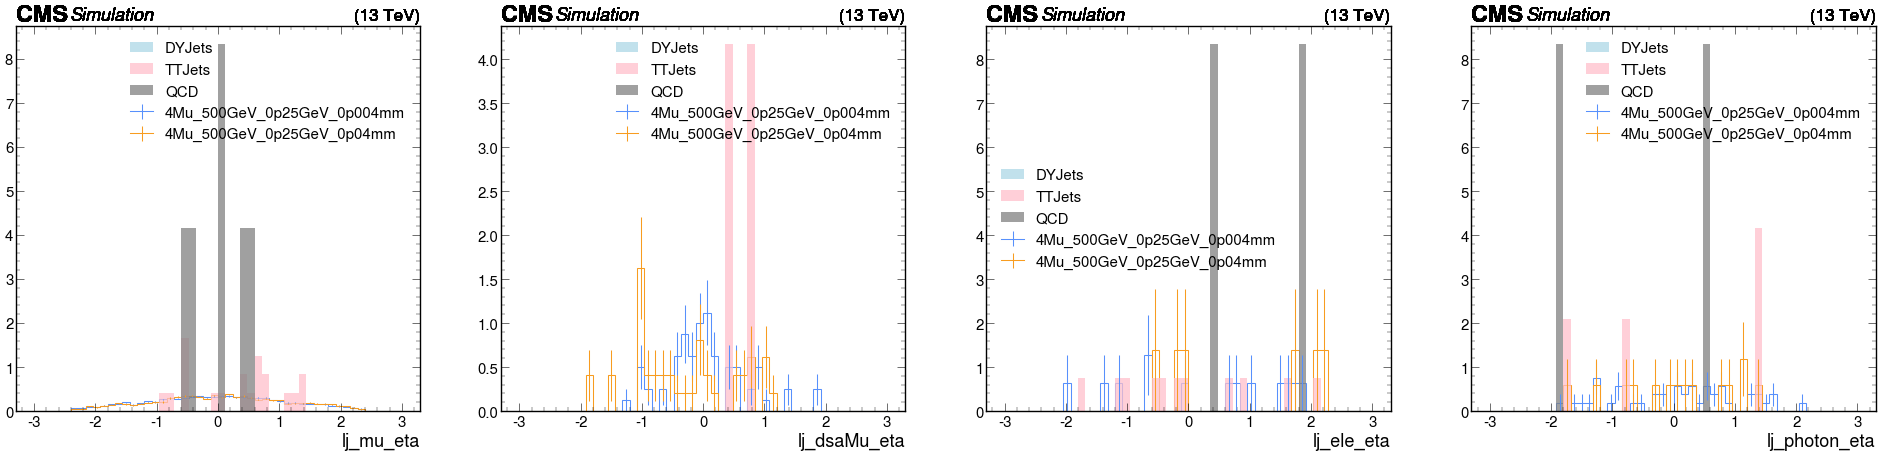

In [12]:
fig, axes = plt.subplots(1,4,figsize=(12*4,10))
hists = ["lj_muon_eta", "lj_dsaMuon_eta", "lj_electron_eta", "lj_photon_eta"]
for i, hist in enumerate(hists):
    legend_list = []
    plt.subplot(1, 4, i+1)
    for plotting_sample in samples_4mu:
        utilities.plot(out[plotting_sample]["hists"][hist][channels[0], :], density=True, label=plotting_sample)
        legend_list.append(plotting_sample)
    for bkg_plotting_sample in samples_bkg:
        if "QCD" in bkg_plotting_sample:
            color = 'gray'
            legend_label = "QCD"
            legend_list.append("QCD")
        elif "TTJets" in bkg_plotting_sample:
            color = 'pink'
            legend_label = "TTJets"
            legend_list.append("TTJets")
        elif "DYJets" in bkg_plotting_sample:
            color = 'lightblue'
            legend_label = "DYJets"
            legend_list.append("DYJets")
        utilities.plot(bkg_out[bkg_plotting_sample]["hists"][hist][channels[0], :], density=True, label=legend_label, color=color, histtype='bar', alpha=.75)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles_labels_dict = {}
    handles_labels_dict = {key: value for key, value in zip(labels, handles)}
    plt.legend(handles_labels_dict.values(), handles_labels_dict.keys())
    # ["Sample1", "Sample2", "DY", "TTJets", "QCD"]

print(f"Handles:\n {handles}\n")
print(f"Labels:\n {labels}\n")
print(f"Dict:\n {handles_labels_dict}")
